# Climate indicators

This notebook is designed to break down different climate indicators.
The datasource are ERA-5 Data on:
https://cloud.google.com/storage/docs/public-datasets/era5?hl=de

(We use this data source because the data is available there in a cloud-optimised format.)

The selected climate indices are:
- Number of summer day
- Number of tropical nights
- ...
    

In [1]:
# reading LIBS

#import thermofeel
#import fsspec
#import gcsfs 
import ephem  # day and night calc
from datetime import datetime, timedelta
#import timezonefinder

#fs = fsspec.filesystem('gs')
import pytz
import os
import glob
from pathlib import Path
import geopandas as gpd
#from loguru import logger
from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
from osgeo import gdal
import subprocess
from osgeo import osr
import pandas as pd
import xarray as xr
import pathlib

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
      
import fsspec

print ("lib done")

lib done


In [2]:
# check data:

fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2/')


arco_era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2', 
    chunks={'time': 48},
    consolidated=True,
)
arco_era5


#for var in arco_era5.data_vars:
#    print(var)

<xarray.Dataset>
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>

In [3]:
# subeset of the big climate data cube:

# select 1 year

##PARAMETER+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++S
## Lux -location: AOI
lat_city=[49]  #### y
lon_city=[6]   #### x
# subest time: TIME-RANGE
start_date = "2018-12-01"; end_date = "2020-12-31";
##PARAMETER+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++E
# update values:  # Kelvin to Degree:
arco_era5['2m_temperature_degree_celcius'] = arco_era5['2m_temperature'] - 273.15

# subeset cube:
#arco_era5_2018_luxembourg = arco_era5['2m_temperature'].sel(time=slice(start_date, end_date),longitude=lon_city,latitude=lat_city)
arco_era5_2018_luxembourg = arco_era5['2m_temperature_degree_celcius'].sel(time=slice(start_date, end_date),longitude=lon_city,latitude=lat_city)

## calculation of different indicators:


## 1. TEMPERATURE indicicators:

## DAY and NIGHT SET:
START_NIGHT_h = 18  
END_NIGHT_h = 6

START_DAY_h = 6
END_DAY_h = 18


## 1.1 MAX and MIN per DAY and NIGHT:

# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

## 1.1.1 MAX
max_temperature_per_day = arco_era5_2018_luxembourg.resample(time='D').max(dim='time')  # calc max and min temp per day
night_time_range = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_NIGHT_h) | (arco_era5_2018_luxembourg['time.hour'] < END_NIGHT_h)))
#max_night_temperature_per_day = night_time_range.resample(time='D').max(dim='time') 


## MAX temp NIGHT per YEAR
max_night_temperature_per_year = night_time_range.resample(time='Y').max(dim='time') 
#print("Max Temp [°C] in the night per year:")
#print(max_night_temperature_per_year.time.dt.year.values.item())
#print(max_night_temperature_per_year.values.item())
#print("---")


day_time_range = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_DAY_h) | (arco_era5_2018_luxembourg['time.hour'] < END_DAY_h)))
#max_day_temperature_per_day = day_time_range.resample(time='D').max(dim='time') 

## MAX temp DAY per YEAR
max_day_temperature_per_year = day_time_range.resample(time='Y').max(dim='time') 
#print("Max Temp [°C] in the day per year:")
#print(max_day_temperature_per_year.time.dt.year.values.item())
#print(max_day_temperature_per_year.values.item())
#print("---")


## 1.1.2 MIN
min_temperature_per_day = arco_era5_2018_luxembourg.resample(time='D').min(dim='time')
#night_time_range = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_NIGHT_h) | (arco_era5_2018_luxembourg['time.hour'] < END_NIGHT_h)))
min_night_temperature_per_day = night_time_range.resample(time='D').min(dim='time') 
#day_time_range = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_DAY_h) | (arco_era5_2018_luxembourg['time.hour'] < END_DAY_h)))
min_day_temperature_per_day = day_time_range.resample(time='D').min(dim='time') 




## 1.2 Number of tropical nights
# Calculate the number of tropical days per year
tropical_threshold = 30
tropical_nights_count_per_year = (max_night_temperature_per_year > tropical_threshold).groupby('time.year').sum()
# Print the result
print("Number of tropical nights per year:")
print("---")
#print(tropical_nights_count_per_year['year'].values.item())
#print(tropical_nights_count_per_year.values.item())
tropical_nights_count_per_year_df = tropical_nights_count_per_year.to_dataframe()
new_column_names = {'2m_temperature_degree_celcius': 'tropical_nights_count_per_year'}
tropical_nights_count_per_year_df.rename(columns=new_column_names, inplace=True)


print(tropical_nights_count_per_year_df)
print("---")




## 1.3 Number of summer days
#Annual count of days when TX (daily maximum temperature) > 25°C. Let TXij be daily minimum temperature on day i in year j. Count the number of days where TXij > 25 °C.
max_temperature_per_day = arco_era5_2018_luxembourg.resample(time='D').max(dim='time')  # calc max and min temp per day

summer_day_threshold = 25
summer_days_count_per_year = (max_temperature_per_day > summer_day_threshold).groupby('time.year').sum()


print("Number of summer days per year:")
print("---")
#print(summer_days_count_per_year['year'].values.item())
#print(summer_days_count_per_year.values.item())
summer_days_count_per_year_df = summer_days_count_per_year.to_dataframe()
new_column_names = {'2m_temperature_degree_celcius': 'summer_days_count_per_year'}
summer_days_count_per_year_df.rename(columns=new_column_names, inplace=True)
print (summer_days_count_per_year_df)
print("---")


#arco_era5_2018_month = arco_era5_2018.resample(time="1M")
#ds =arco_era5_2018_month

#ds_time_subeset = ds.sel(time=slice(start_date, end_date)) 

#ds = ds_time_subeset

#print (arco_era5_2018_luxembourg)
    

#max_temperature_per_day.plot() 

# #


# # Create a single subplot with two columns
# fig, ax = plt.subplots(figsize=(12, 5))
# 
# # Plot the original temperature data
# max_night_temperature_per_day.plot(ax=ax, label='max Temperature per NIGHT', color='blue')
# max_day_temperature_per_day.plot(ax=ax, label='max Temperature per DAY', color='red')
# 
# min_night_temperature_per_day.plot(ax=ax, label='min Temperature per NIGHT', color='green')
# min_day_temperature_per_day.plot(ax=ax, label='min Temperature per DAY', color='black')
# 
# ax.set_title('Maximum % Minimum Temperature per Day and Night')
# ax.set_xlabel('Time')
# ax.set_ylabel('Temperature (°C)')
# ax.legend()
# 
# # Adjust layout to prevent overlap
# plt.tight_layout()
# 
# # Show the plot
# plt.show()
 

# Create subplots with two columns
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the original temperature data
# max_night_temperature_per_day.plot(ax=axes[0], label='max Temperature per NIGHT', color='blue')
# axes[0].set_title('max NIGHTTemperature')
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Temperature (°C)')
# axes[0].legend()
# 
# # Plot the maximum temperature per day
# max_day_temperature_per_day.plot(ax=axes[1], label='max Temperature per DAY', color='red')
# axes[1].set_title('max DAY Temperature per Day')
# axes[1].set_xlabel('Time')
# axes[1].set_ylabel('Temperature (°C)')
# axes[1].legend()
# 
# # Adjust layout to prevent overlap
# plt.tight_layout()
# 
# # Show the plots
# plt.show()



print ("done")


Number of tropical nights per year:
---
                         tropical_nights_count_per_year
year latitude longitude                                
2018 49.0     6.0                                     0
2019 49.0     6.0                                     1
2020 49.0     6.0                                     1
---
Number of summer days per year:
---
                         summer_days_count_per_year
year latitude longitude                            
2018 49.0     6.0                                 0
2019 49.0     6.0                                60
2020 49.0     6.0                                56
---
done


# Universal Thermal Climate Index (UTCI)

In [69]:

print(max_night_temperature_per_year.values.item())


#https://pythermalcomfort.readthedocs.io/en/latest/reference/pythermalcomfort.html#universal-thermal-climate-index-utci



ValueError: can only convert an array of size 1 to a Python scalar

In [29]:


specific_humidity  =0.0003741896762221586

temp_2m_k = 275.54953
#temp_surface_k = 267.25983
windspeed_10m = 2.00436



## Relative humidity (RH) and specific humidity (SH) are related but represent different concepts in meteorology. Specific humidity is the mass of water vapor per unit mass of air, while relative humidity is the ratio of the partial pressure of water vapor to the equilibrium vapor pressure at a given temperature.
##To convert specific humidity to relative humidity, you need additional information such as temperature and pressure. The formula to calculate relative humidity from specific humidity is as follows:
def specific_humidity_to_relative_humidity(specific_humidity, temperature):
    # Constants (for illustration purposes, use actual atmospheric data for accuracy)
    constants = {
        'R': 287.05,  # Specific gas constant for dry air (J/(kg·K))
        'R_v': 461.5,  # Specific gas constant for water vapor (J/(kg·K))
        'epsilon': 0.622,  # Ratio of molecular weights of water vapor to dry air
    }

    # Constants for calculating saturation vapor pressure (for illustration purposes)
    a = 17.27
    b = 237.7

    # Calculate saturation vapor pressure at temperature
    p_sat = 611.2 * np.exp((a * temperature) / (b + temperature))

    # Total atmospheric pressure (for illustration purposes)
    total_pressure = 101325.0  # Pa

    # Calculate relative humidity
    relative_humidity = (specific_humidity * p_sat) / total_pressure * 100.0

    return relative_humidity


relative_humidity = specific_humidity_to_relative_humidity(specific_humidity, temperature=temp_2m_k) 
#print(f"Relative Humidity: {relative_humidity}%")


##The Universal Thermal Climate Index (UTCI) is a measure that combines air temperature, wind speed, relative humidity, and radiation into a single index representing the human-perceived temperature. The formula for calculating UTCI is quite complex and typically requires specialized libraries or tools. However, I can provide you with a simplified example in Python using the formula:


temp_grad =30
temperature = 275  # Replace with the actual air temperature in Celsius
temperature= temp_grad + 273.15
wind_speed = 5  # Replace with the actual wind speed in m/s
relative_humidity = 50  # Replace wi

mean_radiant_temperature_celsius = 29

def calculate_utci(temperature_celsius, wind_speed, relative_humidity, mean_radiant_temperature_celsius):
    # Constants
    a = 17.27
    b = 237.7

    # Convert temperature to Kelvin
    temperature_kelvin = temperature_celsius + 273.15

    # Saturation vapor pressure
    e_s = 0.6108 * np.exp((a * temperature_celsius) / (b + temperature_celsius))

    # Vapor pressure
    e = e_s * (relative_humidity / 100.0)

    # Wind speed at 10 meters
    wind_speed_10m = wind_speed

    # UTCI calculation with Mean Radiant Temperature
    utci = temperature_celsius + 0.607 * e + (5.6 * wind_speed_10m) + (mean_radiant_temperature_celsius - temperature_celsius)

    return utci



# Example usage
#temperature = 25  # Replace with the actual air temperature in Celsius
#wind_speed = 2  # Replace with the actual wind speed in m/s
#relative_humidity = 50  # Replace with the actual relative humidity in percentage

utci_value =  calculate_utci(temperature_celsius=temp_grad, wind_speed=wind_speed, relative_humidity=relative_humidity, mean_radiant_temperature_celsius=mean_radiant_temperature_celsius)


print(f"UTCI: {utci_value}")
print(temperature-273.150)





#https://www.antonellodinunzio.online/web-project/utci-tool/utci-calculator.html




print ("done")

UTCI: 58.284046020487054
30.0
done


In [58]:
# sUniversal Thermal Climate Index (UTCI)

# select 1 year

from thermofeel import (
    calculate_apparent_temperature,
    calculate_bgt,
    calculate_relative_humidity_percent,
    calculate_heat_index_adjusted,
    calculate_heat_index_simplified,
    calculate_humidex,
    calculate_mean_radiant_temperature,
    calculate_mrt_from_bgt,

    calculate_relative_humidity_percent,
    calculate_saturation_vapour_pressure,
    calculate_utci,
    kelvin_to_celsius,
)
##PARAMETER+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++S
## Lux -location: AOI
lat_city=[49]  #### y
lon_city=[6]   #### x
# subest time: TIME-RANGE
start_date = "2020-12-31"; end_date = "2020-12-31";
##PARAMETER+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++E
# update values:  # Kelvin to Degree:


arco_era5['2m_temperature_degree_celcius'] = arco_era5['2m_temperature'] - 273.15


# subeset cube:
#arco_era5_2018_luxembourg = arco_era5['2m_temperature'].sel(time=slice(start_date, end_date),longitude=lon_city,latitude=lat_city)
arco_era5_2018_luxembourg = arco_era5[['2m_temperature', 'temperature', 'specific_humidity','v_component_of_wind']].sel(time=slice(start_date, end_date),longitude=lon_city,latitude=lat_city)

arco_era5_2018_luxembourg['UTCI'] = arco_era5_2018_luxembourg['2m_temperature']+arco_era5_2018_luxembourg['temperature']+arco_era5_2018_luxembourg['specific_humidity']




#print(arco_era5_2018_luxembourg['v_component_of_wind'].sel(level=1).values[0])
# 
# 
# print(arco_era5_2018_luxembourg['temperature'].sel(level=1).values[0])
# print(arco_era5_2018_luxembourg['temperature'].sel(level=10).values[0])
# 
#hum = (arco_era5_2018_luxembourg['specific_humidity'].sel(level=10).values[0].item())
# 
# print(arco_era5_2018_luxembourg['2m_temperature'][0].values)



#print(arco_era5_2018_luxembourg['2m_temperature'][0].values.item())
#print(arco_era5_2018_luxembourg['temperature'][0].values.item())
#print(arco_era5_2018_luxembourg['specific_humidity'][0].values.item())

temp_grad =30
t2m= temp_grad + 273.15
t_surface=temp_grad + 273.15 
humidity =100



relative humidity = (specific humidity) / (saturation point) x 100



td = temp_grad - (100 - relative_humidity) / 5
print("td:")
print (td)


#h_pc = tfc.calculate_relative_humidity_percent(t2m, td)





#t2m = 275.54953
#t_surface = 267.25983
windspeed = 2.00

print (temp_grad)
print (t2m) 
print (t_surface)
print (humidity)
print (windspeed)
#test=thermofeel.calculate_humidex(t2m=t2m, td=td)

#rhp = calculate_relative_humidity_percent(t2k=t2m, tdk=humidity)


#rh_pc = tfc.calculate_relative_humidity_percent(t2m, td)
#ehPa = tfc.calculate_saturation_vapour_pressure(t2m) * rh_pc / 100.0
#utci = thermofeel.calculate_utci(t2_k=t2m, va_ms=ws, mrt_k=mrt, e_hPa=ehPa)
# utci = thermofeel.calculate_utci(t2m, t_surface, windspeed)
#utci = calculate_utci(t2m, windspeed, t_surface)


print(utci )
print(utci-273.15 )

#print (rh_pc)
#print (ehPa)

print ("done")

td:
-351.64850877833294
30
303.15
303.15
100
2.0
-3593063133.218726
-3593063406.3687263
done


In [18]:
# Set the tropical threshold
tropical_threshold = 30  # in degrees Celsius

# Calculate the number of tropical days per year
tropical_days_count_per_year = (arco_era5_2018_luxembourg > tropical_threshold).groupby('time.year').sum()
# Print the result
print("Number of tropical days per year:")
print("---")
print(tropical_days_count_per_year['year'].values.item())
print(tropical_days_count_per_year.values.item())
print("---")


#for year in tropical_days_count_per_year['year']:
#    count = tropical_days_count_per_year.sel(year=year).values.item()
#    print(f"Year {int(year)}: {count} days")

Number of tropical days per year:
---
2020
0
---


In [48]:
max_night_temperature_per_year.time.dt.year

<xarray.DataArray 'year' (time: 1)>
array([2020])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-31

In [51]:
## MAX temp NIGHT per YEAR
max_night_temperature_per_year = night_time_range.resample(time='Y').max(dim='time') 

print("Max Temp [°C] in the night per year:")
print("---")
print(max_night_temperature_per_year.time.dt.year.values.item())

print(max_night_temperature_per_year.values.item())
print("---")



Max Temp [°C] in the night per year:
---
2020
13.408782958984375
---


In [29]:
max_night_temperature_per_year

<xarray.DataArray '2m_temperature_degree_celcius' (time: 1, latitude: 1,
                                                   longitude: 1)>
dask.array<stack, shape=(1, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 49.0
  * longitude  (longitude) float32 6.0
  * time       (time) datetime64[ns] 2020-12-31

In [77]:
night_start, day_start = get_night_and_day_start(latitude, longitude, input_time, timezone)

print (night_start.strftime("%H"))

START_NIGHT_h =  int(night_start.strftime("%H"))
END_NIGHT_h =  int(day_start.strftime("%H"))


print (START_NIGHT_h)
print (END_NIGHT_h)
#night_time_range = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_NIGHT_h) | (arco_era5_2018_luxembourg['time.hour'] < END_NIGHT_h)))
night_time_range_ml = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_NIGHT_h) | (arco_era5_2018_luxembourg['time.hour'] < END_NIGHT_h)))


night_time_range_ml = arco_era5_2018_luxembourg.sel(time=((arco_era5_2018_luxembourg['time.hour'] >= START_NIGHT_h) | (arco_era5_2018_luxembourg['time.hour'] < END_NIGHT_h)))


print (arco_era5_2018_luxembourg['time.date'])
print (get_night_and_day_start(latitude, longitude, int(arco_era5_2018_luxembourg['time.hour']), timezone))

15
15
8
<xarray.DataArray 'date' (time: 744)>
array([datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 1),
       datetime.date(2020, 12, 2), datetime.date(2020, 12, 2),
       datetime.date(2020, 12, 2), datetime.date(2020, 12, 2),
       datetime.date(2020, 12, 2), datetime.date(2020, 12, 2),
       da

TypeError: only size-1 arrays can be converted to Python scalars

In [48]:

from datetime import datetime

lat_city=49  #### y
lon_city=6   #### x

lat = float(lat_city)
lon = float(lon_city)




def get_night_and_day_start(lat, lon, input_time, timezone='UTC'):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)

    sun = ephem.Sun()

    # Convert the input time to UTC
    input_datetime = datetime.strptime(input_time, "%Y-%m-%d")
    input_datetime_utc = pytz.utc.localize(input_datetime)

    observer.date = input_datetime_utc

    # Calculate sunset and sunrise times
    sunset = observer.previous_setting(sun)
    sunrise = observer.next_rising(sun)

    # Define a custom function to convert ephem date to Python datetime with timezone
    def ephem_date_to_datetime(ephem_date):
        return ephem_date.datetime().replace(tzinfo=pytz.utc)
   
   ### custom function to round the time to the NEXT hour:
    def hour_rounder(t):
   # Rounds to nearest hour by adding a timedelta hour if minute >= 30
       return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
                  +timedelta(hours=t.minute//30))
    

    # Calculate the start of the night (sunset to sunrise) and day (sunrise to sunset)
    night_start = ephem_date_to_datetime(sunset) - timedelta(minutes=30)  # 30 minutes before sunset
    day_start = ephem_date_to_datetime(sunrise) + timedelta(minutes=30)  # 30 minutes after sunrise

    # Convert the results to the specified local timezone
    night_start_local = hour_rounder(night_start.astimezone(pytz.timezone(timezone)))
    day_start_local =   hour_rounder(  day_start.astimezone(pytz.timezone(timezone)))

    return night_start_local, day_start_local



# Example usage
latitude = 49  # Example latitude (San Francisco)
longitude = 6  # Example longitude (San Francisco)
input_time = '2024-01-11'  # Example input time in the format 'YYYY-MM-DD HH:MM:SS'
timezone = 'UTC'  # Example timezone


night_start, day_start = get_night_and_day_start(latitude, longitude, input_time, timezone)



print(f"Start of the night: {night_start}")
print(f"Start of the day: {day_start}")




Start of the night: 2024-01-10 15:00:00+00:00
Start of the day: 2024-01-11 08:00:00+00:00


In [29]:
import datetime
from dateutil import tz
print (day_start)

print(day_start.now().replace(microsecond=0, second=0, minute=0) - timedelta(hours=1))

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

print(hour_rounder(day_start))


2024-01-11 07:57:04.555165+00:00
2024-01-11 07:00:00
2024-01-11 08:00:00+00:00


In [102]:
arco_era5_2018['2m_temperature_degree_celcius'] = arco_era5['2m_temperature'] - 273.15

ds=arco_era5_2018

lon_index = list(ds.longitude.values).index(ds.sel(longitude=lon_city, method='nearest').longitude)
lat_index = list(ds.latitude.values).index(ds.sel(latitude=lat_city,   method='nearest').latitude)
print (lat_index)
print (lon_index)


city_location = arco_era5_2018.isel( lon=lon_index,lat=lat_index)
#print (city_location) ## location of city
#print (arco_era5_2018)

164
24


CPU times: user 357 ms, sys: 31.5 ms, total: 389 ms
Wall time: 2.14 s


/home/conda/fairicubeuc1/467086c01351ef630f14ef1c1e2c3607605786e25d92214e8ed7a5ca85b36969-20230703-150612-959289-12-fairicube_env/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


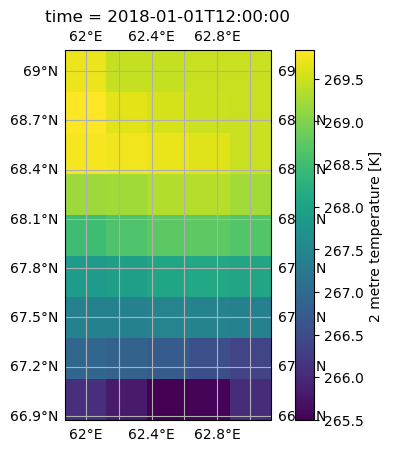

In [44]:
%%time
#plot 2m temperature for 1 timestamp


subset = arco_era5_2018['2m_temperature'].sel(time='2018-01-01T12:00:00.000000000', longitude=slice(62,63),latitude=slice(69,67))#, level=1)

ax = plt.subplot(projection=ccrs.PlateCarree())

subset.plot.pcolormesh(x="longitude", y="latitude", ax=ax, infer_intervals=True)
ax.coastlines()
ax.gridlines(draw_labels=True)


In [37]:
# reading the input climate data

input_folder ="./../../../s3/data/d002_urban_atlas"
input_folder ="./../../../../s3/data/d003_climate/cl_02_e_obs/"
# assign directory
directory = input_folder
print (directory)
print ("following nc file wil be used:")

# that directory
#for filename in os.scandir(directory):
#    print (filename)
        
    
file_nc = "tg_ens_mean_01deg_reg_v280e.nc"
nc_file = input_folder+"/"+file_nc
ds = xr.open_dataset(nc_file)
print (ds)

# #
print("list variables:")
print (list(ds.keys()))
print("list dims:")
print (list(ds.coords))
# ds


## Lux -location:
lat_city=[49]  #### y
lon_city=[6]   #### x

# subest time:
start_date = "2015-12-31"; end_date = "2020-12-31";
ds_time_subeset = ds.sel(time=slice(start_date, end_date)) 

ds = ds_time_subeset

print (ds.tg.attrs)  # check attributes
print (ds.time.attrs)  # check attributes



# Convert or name values:
tg = ds.tg
#copy attributes to get nice figure labels and change Kelvin to Celsius
#utci.attrs = ds.tg.attrs
#utci.attrs["units"] = "C"
#subset = arco_era5_2018['2m_temperature'].sel(time='2018-01-01T12:00:00.000000000', longitude=slice(62,63),latitude=slice(69,67))#, level=1)



#lon_index = list(ds.longitude.values).index(ds.sel(longitude=lon_city, method='nearest').longitude)
#lat_index = list(ds.latitude.values).index(ds.sel(latitude=lat_city, method='nearest').latitude)
#print (lat_index)
#print (lon_index)
#city_location_df = tg.isel( longitude=lon_index,latitude=lat_index)
#print (city_location_df) ## location of city




# Assuming ds is your xarray dataset with temperature information
# Define the threshold for tropical days

tropical_threshold = 30  # in degrees Celsius
tropical_days_count = (city_location_df > tropical_threshold).sum(dim='time')
print(f"Number of tropical days: {tropical_days_count.values}")





#print(f"Number of tropical days: {tropical_days_count.values}")


#TG_location = TG.isel(X=6,Y=49)
#city_location.plot() 
print ("done")

./../../../../s3/data/d003_climate/cl_02_e_obs/
following nc file wil be used:
<xarray.Dataset>
Dimensions:    (latitude: 465, longitude: 705, time: 26844)
Coordinates:
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-06-30
Data variables:
    tg         (time, latitude, longitude) float32 ...
Attributes:
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    E-OBS_version:  28.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Sep 22 09:13:27 2023: ncks --no-abc -d time,0,26843 /...
list variables:
['tg']
list dims:
['latitude', 'longitude', 'time']
{'units': 'Celsius', 'long_name': 'mean temperature', 'standard_name': 'air_temperature', 'cell_methods': 'time: mean'}
{'long_name': 'Time in days', 's

Number of tropical days: 1


TypeError: No numeric data to plot.

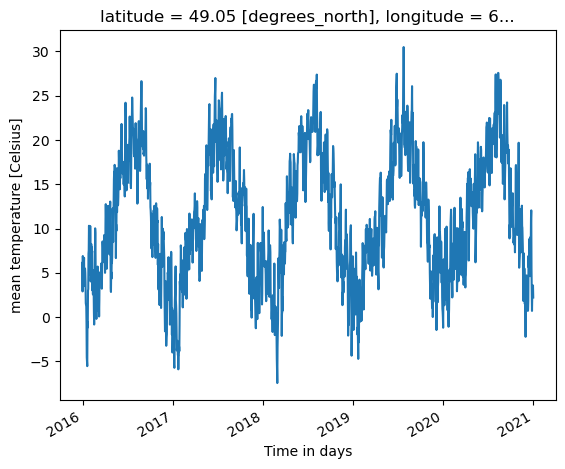

In [39]:


# Assuming ds is your xarray dataset with temperature information
# Define the threshold for tropical days

tropical_threshold = 30  # in degrees Celsius
tropical_days_count = (city_location_df > tropical_threshold).sum(dim='time')
print(f"Number of tropical days: {tropical_days_count.values}")





#print(f"Number of tropical days: {tropical_days_count.values}")


#TG_location = TG.isel(X=6,Y=49)
city_location_df.plot() 
tropical_days_count.plot() 

#days_exceeding_threshold_per_year = tropical_days_count.groupby(time).sum()


#ätropical_days_count = (max_temp_data > tropical_threshold).sum(dim='time')